<h1 style="color:Blue">Barzilai-Borwein Step Size for Stochastic Gradient Descent</h1>

## Introduction
The Barzilai-Borwein (BB) step size is a technique originally developed for gradient descent methods in deterministic optimization to automatically update step size without having to manually tune the parameter

This method is proven to solve nonlinear optimization problem successfully and the key idea behind the approach is that it uses quasi-newton method. From equation (7) and (6) its shows that BB method does not require any parameters as the step size is calculated while running the algorithm. The pseudo code for the algorithm is given.

[(2016) Barzilai-Borwein Step Size for Stochastic Gradient Descent Conghui Tan, Shiqian Ma, Yu-Hong Dai, Yuqiu Qian
](https://papers.nips.cc/paper_files/paper/2016/hash/c86a7ee3d8ef0b551ed58e354a836f2b-Abstract.html)


<h2 style="color:Blue">Problem Statement</h2>
To do classification task on MNIST data and apply the proposed algorithm on MNIST dataset.

<h2 style="color:Blue">Scope of Project</h2>

- My scope of the project is to compare three algorithms.
    - Stochastics Gradient Descent, 
    - Stochastic Variance Reduced Gradient 
    - Stochastic Variance Reduced Gradient - BB method 

In [84]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [41]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Adjust the size of the training data
train_samples = 40000
x_train = x_train[:train_samples]
y_train = y_train[:train_samples]

# Flatten images and normalize
x_train = x_train.reshape(x_train.shape[0], -1).astype(np.float32) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1).astype(np.float32) / 255.0

# Append a column of ones for bias term
x_train = np.c_[np.ones(x_train.shape[0]), x_train]
x_test = np.c_[np.ones(x_test.shape[0]), x_test]

(-0.5, 27.5, 27.5, -0.5)

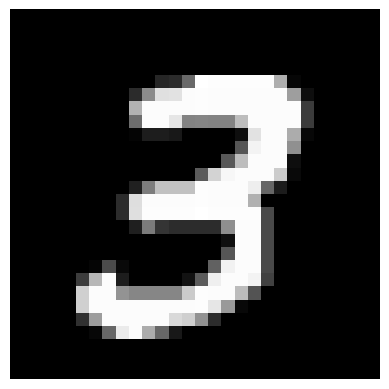

In [107]:
plt.imshow(x_train[7, 1:].reshape(28, 28), cmap='gray')
plt.axis('off')

In [108]:
x_train.shape, x_test.shape

((40000, 785), (10000, 785))

In [109]:
x_train[0].shape

(785,)

In [111]:
y_train.shape, y_test.shape

((40000, 10), (10000, 10))

In [112]:
y_train[0].shape

(10,)

In [45]:
# One-hot encode labels
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train = one_hot_encode(y_train)  # Shape: (train_samples, 10)
y_test = one_hot_encode(y_test)    # Shape: (10000, 10)

In [46]:
y_train, y_train[0].shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (10,))

In [125]:
# Since I was getting error, I follow trick from https://cs231n.github.io/linear-classify/#svm-vs-softmax 
def softmax(a):
    if a.ndim == 1:
        a = a.reshape(1, -1)  # Reshape to (1, num_classes)
    exp_a = np.exp(a - np.max(a, axis=1, keepdims=True))
    return exp_a / np.sum(exp_a, axis=1, keepdims=True)

# this computes the loss given in the below cell and its uses np.outer to computer the product.
def gradient_cross_entropy_single(x, y_true, y_pred):
    # y_pred is (1, num_classes), flatten to (num_classes,)
    y_pred = y_pred.flatten()
    return np.outer(x, (y_pred - y_true))

# Cross-entropy loss
def cross_entropy_clip(w, x, y):
    y_hat = softmax(np.matmul(x, w))
    eps = 1e-10
    return -np.sum(y * np.log(y_hat + eps)) / x.shape[0]

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{W}} = \mathbf{x} \cdot (\mathbf{y}_{\text{pred}} - \mathbf{y}_{\text{true}})^T
$$

I have used this **np.outer** to calculate the above product since x is a vector and y is a vector

## Example of np.outer

In [121]:
np.ones((5,)), np.linspace(-2, 2, 5)

(array([1., 1., 1., 1., 1.]), array([-2., -1.,  0.,  1.,  2.]))

In [124]:
rl = np.outer(np.ones((5,)), np.linspace(-2, 2, 5))
rl

array([[-2., -1.,  0.,  1.,  2.],
       [-2., -1.,  0.,  1.,  2.],
       [-2., -1.,  0.,  1.,  2.],
       [-2., -1.,  0.,  1.,  2.],
       [-2., -1.,  0.,  1.,  2.]])

<h2 style="color:blue">Stochastic Gradient Descent</h2>

Stochastic Gradient Descent (SGD) is an optimization algorithm used to minimize a differentiable objective function, typically in machine learning for training models. Unlike standard gradient descent, which computes the gradient using the entire dataset, SGD approximates the gradient using a single example at each iteration, making it computationally efficient for large datasets.

Algorithm
1. Initialize: $ x_0 $ to an initial guess (e.g., random or zero vector). \n
2. **for** $k = 0, 1, 2, \dots T-1$ **do**:  
   1. Randomly select a training example $x_i$ from the dataset.
   2. Compute the gradient of the loss with respect to $ \theta_k $ for the selected example:$g_k = \nabla_x \ell(\theta_k; x_i)$
   3. Update the parameters:$\theta_{k+1} = \theta_k - \gamma_k g_k$


In [56]:
# SGD algorithm
def sgd(w_initial, x_train, y_train, eta, m, num_epochs):
    w = w_initial.copy()
    n = x_train.shape[0]
    loss_vals = []
    
    for k in range(num_epochs):
        for t in range(m):
            # Randomly select a sample
            i_t = np.random.randint(0, n)
            x_i = x_train[i_t]  # Shape: (785,)
            y_i = y_train[i_t]  # Shape: (10,)
            
            # Compute stochastic gradient
            y_hat_t = softmax(np.dot(x_i, w))  # Shape: (1, 10)
            grad_t = gradient_cross_entropy_single(x_i, y_i, y_hat_t)  # Shape: (785, 10)
            
            # Update weights
            w = w - eta * grad_t
        
        # Compute and store loss after each epoch
        loss = cross_entropy_clip(w, x_train, y_train)
        loss_vals.append(loss)
    
    return w, np.array(loss_vals)


<h3 style="color:blue"> SVRG-BB Algorithm from the paper</h3>
---

**Input**:  
- $m$ (epoch length)  
- Initial point $\tilde{x}_0$ 
- Initial step size $\eta_0$ (used only in the first epoch)  

**Output**: Optimized parameters $ \tilde{x}_k $ - in the code i have used w to represent $\tilde{x}$


---

1. **for** $k = 0, 1, 2, \dots$ **do**:  
   1. Compute full gradient:  
      $g_k = \frac{1}{n} \sum_{i=1}^n \nabla f_i(\tilde{x}_k)$  
   2. **if** $k > 0 $:  
      - Compute BB step size:  
        $\eta_k = \frac{1}{m} \cdot \frac{\| \tilde{x}_k - \tilde{x}_{k-1} \|_2^2}{(\tilde{x}_k - \tilde{x}_{k-1})^\top (g_k - g_{k-1})}$  
   3. Initialize inner loop:  
      $x_0 = \tilde{x}_k$  
   4. **for** $t = 0, 1, \dots, m-1$ **do**:  
      1. Randomly sample $i_t \in \{1, \dots, n\} $.  
      2. Update parameters:  
         $x_{t+1} = x_t - \eta_k \left( \nabla f_{i_t}(x_t) - \nabla f_{i_t}(\tilde{x}_k) + g_k \right)$  
   5. **Option I** (Default):  
      $\tilde{x}_{k+1} = x_m \quad \text{(Use final inner iterate)}$
      **Option II** (Randomized):  
      $\tilde{x}_{k+1} = x_t \quad \text{(for random } t \in \{1, \dots, m\})$  

---

For step E I used the option I

## The code for SVRG and SVRG-BB algorithm is the same, the only difference is that SVRG does not compute BB method(step size) at every epoch.

In [99]:
# SVRG algorithm
def svrg(w_initial, x_train, y_train, eta, m, num_epochs):
    w = w_initial.copy()
    n = x_train.shape[0]
    loss_vals = []
    
    for k in range(num_epochs):
        # Compute full gradient
        y_hat = softmax(np.matmul(x_train, w))  # Shape: (n, 10)
        g_k = np.matmul(x_train.T, (y_hat - y_train)) / n  # Shape: (785, 10)
        x_t = w.copy()
        
        # Compute BB step size not required for SVRG
        #if k > 0:
        #    s_k = w - w_prev  # Shape: (785, 10)
        #    y_k = g_k - g_prev  # Shape: (785, 10)
        #    s_norm = np.sum(s_k ** 2)
        #    s_y = np.sum(s_k * y_k)
        #    eta = (s_norm / (m * s_y)) if s_y > 1e-10 else eta_0 # To Avoid division by zero or negative step sizes
        
        #x_t = w.copy()
        
        # Inner loop
        for t in range(m):
            i_t = np.random.randint(0, n)
            x_i = x_train[i_t]  # Shape: (785,)
            y_i = y_train[i_t]  # Shape: (10,)
            
            y_hat_t = softmax(np.dot(x_i, x_t))  # Shape: (1, 10)
            grad_t = gradient_cross_entropy_single(x_i, y_i, y_hat_t)  # Shape: (785, 10)
            
            # Compute reference gradient at w
            y_hat_w = softmax(np.dot(x_i, w))  # Shape: (1, 10)
            grad_w = gradient_cross_entropy_single(x_i, y_i, y_hat_w)  # Shape: (785, 10)
            
            # Variance-reduced gradient
            v_t = grad_t - grad_w + g_k
            x_t = x_t - eta * v_t
        
        w = x_t  # Option I: Update w to last iterate
        loss = cross_entropy_clip(w, x_train, y_train)
        loss_vals.append(loss)
    
    return w, np.array(loss_vals)

In [100]:
# SVRG-BB algorithm
def svrg_bb(w_initial, x_train, y_train, eta_0, m, num_epochs):
    w = w_initial.copy()
    n = x_train.shape[0]
    loss_vals = []
    eta = eta_0
    w_prev = w.copy()
    g_prev = None
    
    for k in range(num_epochs):
        # full gradient 
        y_hat = softmax(np.matmul(x_train, w))  # Shape: (n, 10)
        g_k = np.matmul(x_train.T, (y_hat - y_train)) / n  # Shape: (785, 10)
        
        # Compute BB step size
        if k > 0:
            s_k = w - w_prev  # Shape: (785, 10)
            y_k = g_k - g_prev  # Shape: (785, 10)
            s_norm = np.sum(s_k ** 2)
            s_y = np.sum(s_k * y_k)
            eta = (s_norm / (m * s_y)) if s_y > 1e-10 else eta_0 # To Avoid division by zero or negative step sizes
        
        x_t = w.copy()
        
        # Inner loop
        for t in range(m):
            i_t = np.random.randint(0, n)
            x_i = x_train[i_t]  # Shape: (785,)
            y_i = y_train[i_t]  # Shape: (10,)
            
            # Compute stochastic gradient
            y_hat_t = softmax(np.dot(x_i, x_t))  # Shape: (1, 10)
            grad_t = gradient_cross_entropy_single(x_i, y_i, y_hat_t)  # Shape: (785, 10)
            
            # calculate reference gradient at w
            y_hat_w = softmax(np.dot(x_i, w))  # Shape: (1, 10)
            grad_w = gradient_cross_entropy_single(x_i, y_i, y_hat_w)  # Shape: (785, 10)
            
            # Variance-reduced gradient
            v_t = grad_t - grad_w + g_k
            x_t = x_t - eta * v_t
        
        w_prev = w.copy()
        g_prev = g_k.copy()
        w = x_t  # Option I
        loss = cross_entropy_clip(w, x_train, y_train)
        loss_vals.append(loss)
    
    return w, np.array(loss_vals)

In [101]:
# Prediction function
def predict(x, w):
    y_pred = np.dot(x, w)
    return np.argmax(softmax(y_pred), axis=1)

# Confusion matrix computation
def compute_confusion(x_test, y_test, w):
    y_pred = predict(x_test, w)
    y_test_labels = np.argmax(y_test, axis=1)
    cm = confusion_matrix(y_test_labels, y_pred)
    return cm

In [115]:
w_sgd1, loss_sgd1 = sgd(w_initial, x_train, y_train, eta_0, m, num_epochs)
w_svrg1, loss_svrg1 = svrg(w_initial, x_train, y_train, eta_0, m, num_epochs)
w_svrg_bb1, loss_svrg_bb1 = svrg_bb(w_initial, x_train, y_train, eta_0, m, num_epochs)

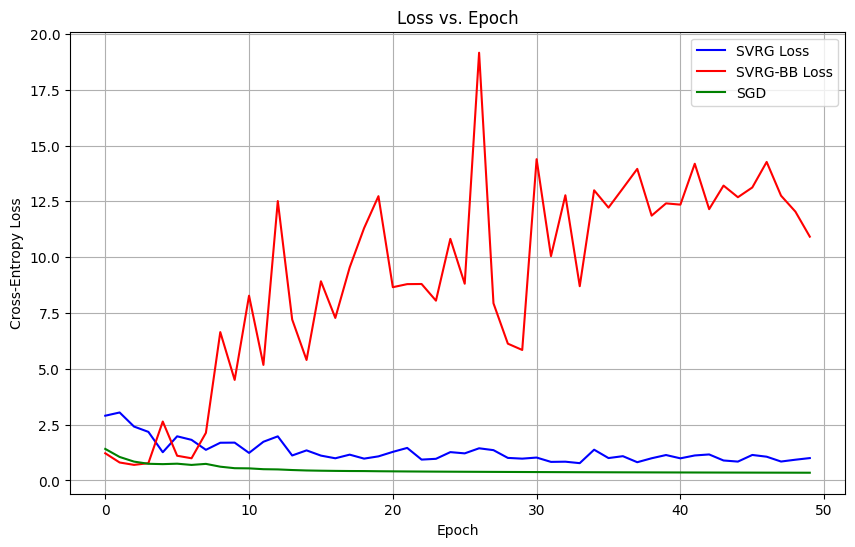

In [116]:
# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(loss_sgd1, 'b-', label='SVRG Loss')
plt.plot(loss_svrg_bb1, 'r-', label='SVRG-BB Loss')
plt.plot(loss_svrg1, 'g-', label="SGD")
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.savefig("SGDvsBB.png")
plt.show()
# fig.savefig('my_figure.png') # Saves as PNG in current directory


## parameters 

- $m$ is set to $2n$ (as per the paper), $m = 2 * 40000$ (training size), so it will take long time to run.

In [60]:
# Parameters
w_initial = np.zeros((785, 10))
eta_svrg = 0.1  # Fixed step size for SVRG
eta_0 = 0.1     # Initial step size for SVRG-BB
m = 2 * x_train.shape[0]  # Inner loop iterations (2n as suggested), same for all methods
num_epochs = 50

In [61]:
# Run SGD
w_sgd, loss_sgd = sgd(w_initial, x_train, y_train, eta_0, m, num_epochs)

In [63]:
w_sgd.shape

(785, 10)

In [64]:
# Run SVRG
w_svrg, loss_svrg = svrg(w_initial, x_train, y_train, eta_svrg, m, num_epochs)

In [65]:
w_svrg.shape

(785, 10)

In [66]:
# Run SVRG-BB
w_svrg_bb, loss_svrg_bb = svrg_bb(w_initial, x_train, y_train, eta_0, m, num_epochs)

In [67]:
w_svrg.shape

(785, 10)

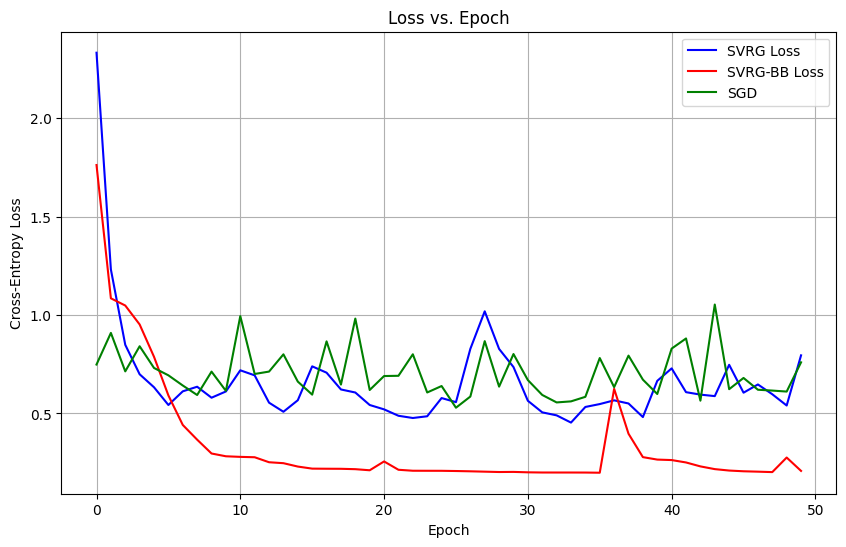

In [68]:
# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(loss_svrg, 'b-', label='SVRG Loss')
plt.plot(loss_svrg_bb, 'r-', label='SVRG-BB Loss')
plt.plot(loss_sgd, 'g-', label="SGD")
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.savefig("SGDvsBB.png")
plt.show()
# fig.savefig('my_figure.png') # Saves as PNG in current directory


In [69]:
# Evaluation
y_test_labels = np.argmax(y_test, axis=1)

y_pred_sgd = predict(x_test, w_sgd)
y_pred_svrg = predict(x_test, w_svrg)
y_pred_svrg_bb = predict(x_test, w_svrg_bb)

train_accuracy_sgd = accuracy_score(np.argmax(y_train, axis=1), predict(x_train, w_sgd))
test_accuracy_sgd = accuracy_score(y_test_labels, y_pred_sgd)

train_accuracy_svrg = accuracy_score(np.argmax(y_train, axis=1), predict(x_train, w_svrg))
test_accuracy_svrg = accuracy_score(y_test_labels, y_pred_svrg)

train_accuracy_svrg_bb = accuracy_score(np.argmax(y_train, axis=1), predict(x_train, w_svrg_bb))
test_accuracy_svrg_bb = accuracy_score(y_test_labels, y_pred_svrg_bb)

In [95]:
print(f"\nSVRG Training Accuracy: {train_accuracy_svrg:.4f}")
print(f"SGD Test Accuracy: {test_accuracy_sgd:.4f}")
print(f"SVRG Test Accuracy: {test_accuracy_svrg:.4f}")
print(f"SVRG-BB Training Accuracy: {train_accuracy_svrg_bb:.4f}")
print(f"SVRG-BB Test Accuracy: {test_accuracy_svrg_bb:.4f}")


SVRG Training Accuracy: 0.8761
SGD Test Accuracy: 0.8738
SVRG Test Accuracy: 0.8576
SVRG-BB Test Accuracy: 0.9167


## Train vs Test Accuracy

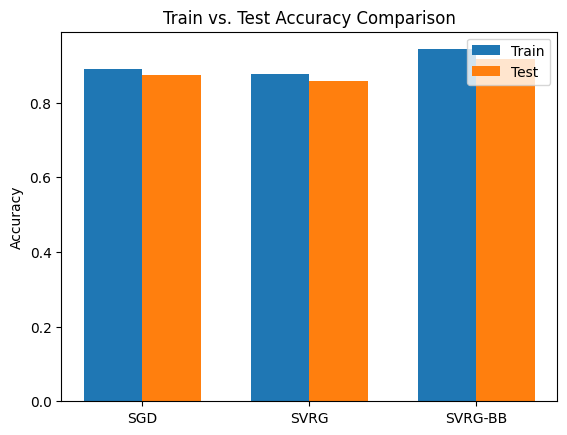

In [76]:
methods = ['SGD', 'SVRG', 'SVRG-BB']
train_acc = [train_accuracy_sgd, train_accuracy_svrg, train_accuracy_svrg_bb]
test_acc  = [test_accuracy_sgd,  test_accuracy_svrg,  test_accuracy_svrg_bb]

x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, train_acc, width, label='Train')
ax.bar(x + width/2, test_acc,  width, label='Test')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylabel('Accuracy')
ax.set_title('Train vs. Test Accuracy Comparison')
ax.legend()
plt.show()

## Confusion matrix

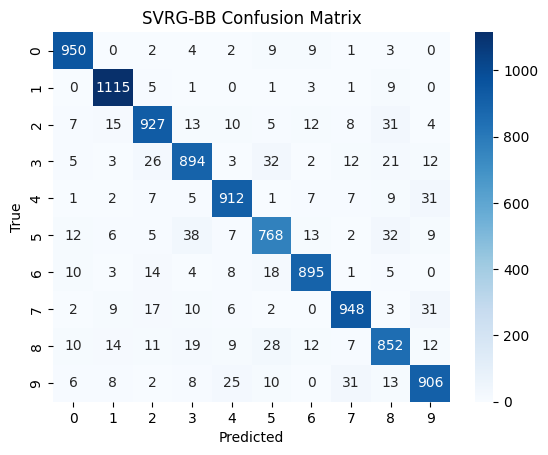

In [78]:
# I only just plotted for SVRG-BB.
cm = confusion_matrix(y_test_labels, y_pred_svrg_bb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVRG-BB Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Misclassification for SVRG-BB

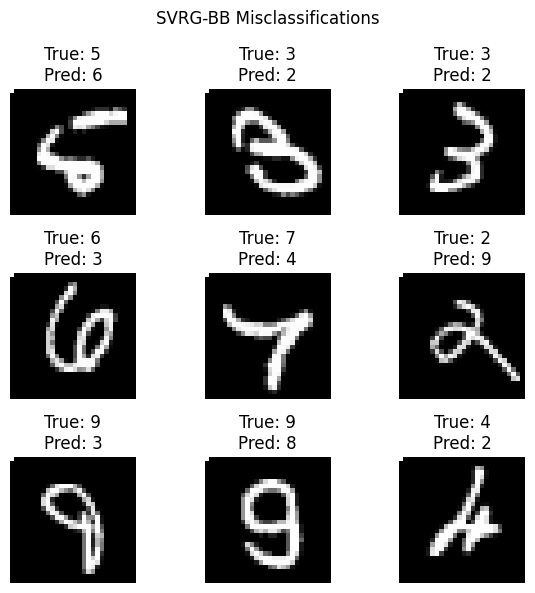

In [92]:
# we need to remove the last column to flatten the image
images_flat = x_test[:, :-1]   # now shape (N, 784)

wrong = np.where(y_pred_svrg_bb != y_test_labels)[0][:9]
fig, axes = plt.subplots(3, 3, figsize=(6,6))
for ax, idx in zip(axes.flatten(), wrong):
    img = images_flat[idx].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {y_test_labels[idx]}\nPred: {y_pred_svrg_bb[idx]}")
    ax.axis('off')
plt.suptitle('SVRG-BB Misclassifications')
plt.tight_layout()
plt.show()

## Plot Prediction 

In [93]:
def plot_examples(X, y_true, y_pred, num_examples=10):
    indices = np.random.choice(X.shape[0], size=num_examples, replace=False)
    fig, axes = plt.subplots(1, num_examples, figsize=(10, 2))
    for i, idx in enumerate(indices):
        axes[i].imshow(X[idx, 1:].reshape(28, 28), cmap='gray')
        axes[i].set_title(f"True: {y_true[idx]}\nPred: {y_pred[idx]}")
        axes[i].axis('off')
    plt.show()


Sample predictions (SVRG-BB):


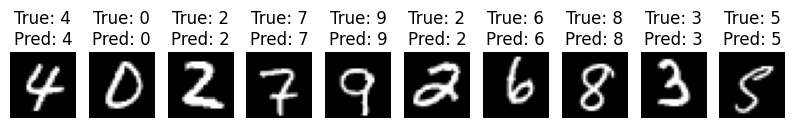

In [94]:
print("\nSample predictions (SVRG-BB):")
plot_examples(x_test, y_test_labels, y_pred_svrg_bb)

<h3 style="color:blue">Run with different Learning Rates</h3>

## This will take very long time to run since I am using  $ \eta=[0.01, 0.1, 0.5]$   values with $m=2n$ for all the three algorithm

In [10]:
# Parameters
w_initial = np.zeros((785, 10))
eta_values = [0.01, 0.1, 0.5] 
m = 2 * x_train.shape[0] # (2n as suggested in the paper)
num_epochs = 50

In [11]:
# Run experiments for each eta value
results = {'SGD': {}, 'SVRG': {}, 'SVRG-BB': {}}

for eta in eta_values:
    print(f"Running experiments with eta={eta}")
    
    # Run SGD
    w_sgd, loss_sgd = sgd(w_initial, x_train, y_train, eta, m, num_epochs)
    results['SGD'][eta] = loss_sgd
    
    # Run SVRG
    w_svrg, loss_svrg = svrg(w_initial, x_train, y_train, eta, m, num_epochs)
    results['SVRG'][eta] = loss_svrg
    
    # Run SVRG-BB (using eta as initial step size)
    w_svrg_bb, loss_svrg_bb = svrg_bb(w_initial, x_train, y_train, eta, m, num_epochs)
    results['SVRG-BB'][eta] = loss_svrg_bb

Running experiments with eta=0.01
Running experiments with eta=0.1
Running experiments with eta=0.5


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

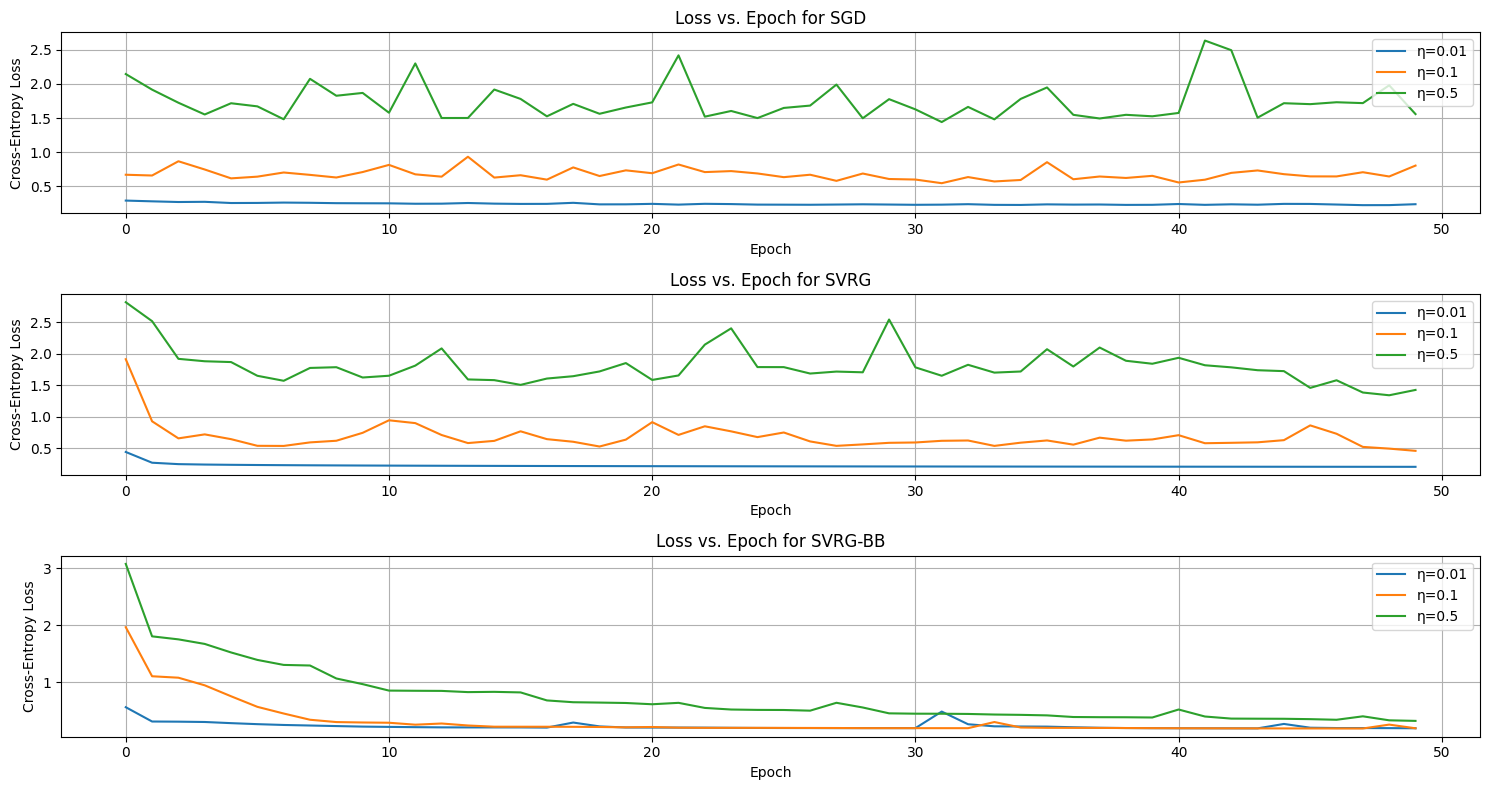

In [14]:
# Plot for each algorithm
# Plot results
plt.figure(figsize=(15, 8))
for i, algorithm in enumerate(results.keys()):
    plt.subplot(3, 1, i+1)
    for eta in eta_values:
        plt.plot(results[algorithm][eta], label=f'η={eta}')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.title(f'Loss vs. Epoch for {algorithm}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig("Algorithm_Comparison.png")
plt.show()

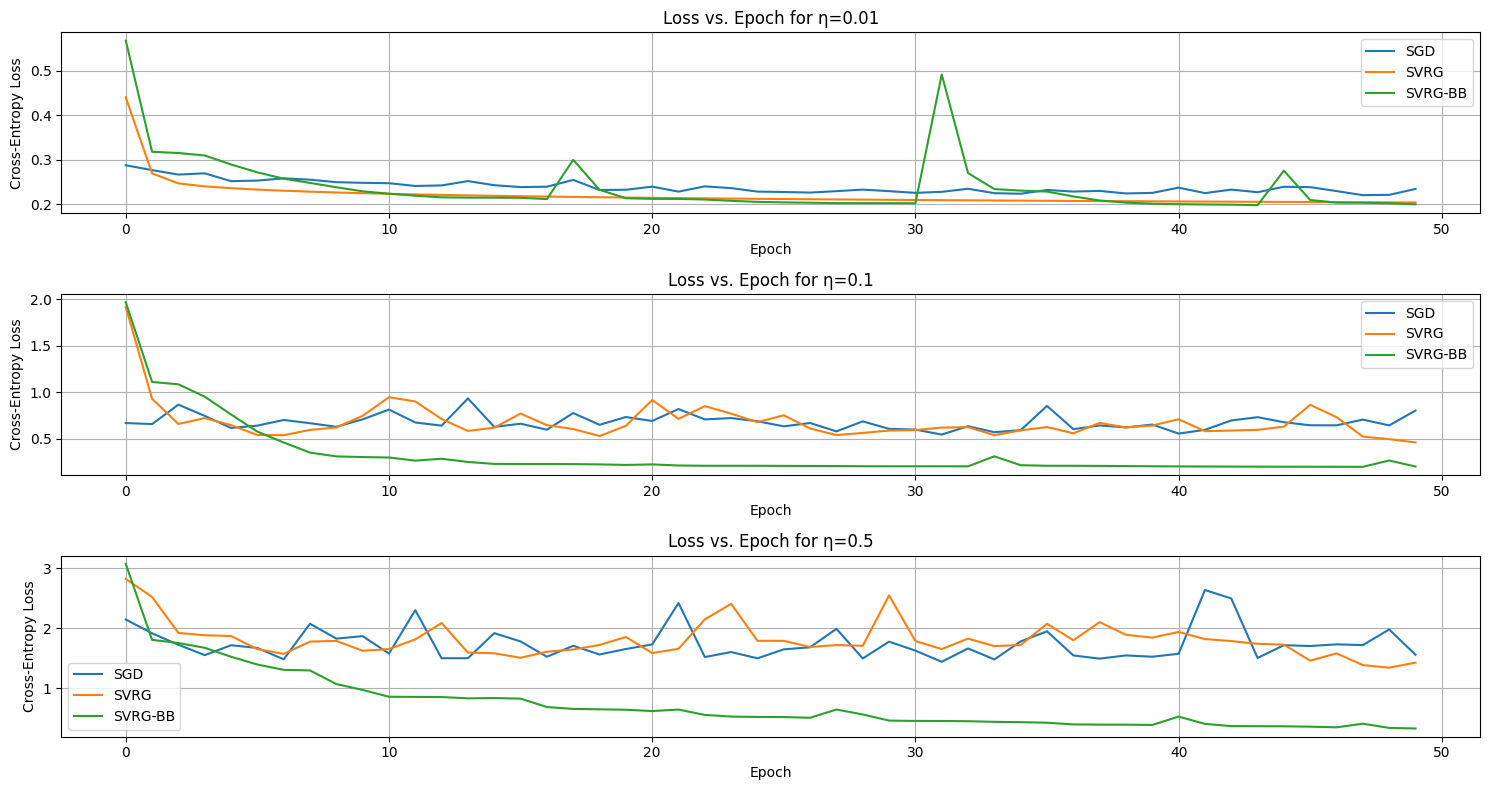

In [15]:
# Plot all algorithms together for each eta
plt.figure(figsize=(15, 8))
for i, eta in enumerate(eta_values):
    plt.subplot(3, 1, i+1)
    for algorithm in results.keys():
        plt.plot(results[algorithm][eta], label=f'{algorithm}')
    plt.xlabel('Epoch')
    plt.ylabel('Cross-Entropy Loss')
    plt.title(f'Loss vs. Epoch for η={eta}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig("Eta_Comparison.png")
plt.show()